# Setting up the analysis
This notebook will outline how to get setup to run a ctools analysis of VERITAS data. At this point you should have all of your data files formatted into DL3 compatible FITS files. 

In [1]:
# Import the GammaLib and ctools relevant moduals
import gammalib
import ctools
import cscripts

# We will also use matplotlib for visualization
%matplotlib inline
import matplotlib.pyplot as plt

## Assembling the observation definition file
In order to use these files in the various ctools we need to create an observation definition XML file. This file tells ctools and GammaLib where to find all of the necessary IRF components for each file. 

To start, create a text file that contains the full path to each file on a new line. It should look something like this:
```
/home/user/path/to/54809.fits
/home/user/path/to/57993.fits
```
You can find an example runlist file that will be used in this tutorial here:
    `$V2DL3/notebooks/tutorials/ctools/resources/tutorial_runlist.txt`
    
The following code will loop through each file, setup a `GObservation` object for each file, and fill all those observations into a `GObservations` object that can be saved to a file for use in the various tools.

In [2]:
# Load the file
runs    = open('resources/tutorial_runlist.txt', 'rt')
obsfile = 'resources/obs.xml'

# Create an observation container
obs_list = gammalib.GObservations()

# Loop through each line
for line in runs:
    line = line.strip()
    # Load the observation and relavant information
    obs  = gammalib.GCTAObservation(line)
    
    # Load each of the IRF objects
    response = gammalib.GCTAResponseIrf()
    response.load_aeff(line)
    response.load_edisp(line)
    
    # Make sure the PSF information is in the file
    try:
        response.load_psf(line)
    except:
        print("No psf info found in file. Make sure you're running a point-like analysis!")
        # PSF information is not available in standard EA files
        # so we need to get creative by loading dummy PSF 
        # information so ctools will at least give reasonable results
        response.load_psf("$CTOOLS/share/caldb/data/cta/prod2/bcf/North_50h/irf_file.fits.gz")
        
    # Set the response
    obs.response(response)
    obs.name("VTS_Obs")
    
    # Add the observation to the list
    obs_list.append(obs)
    
# Write the observation file
obs_list.save(obsfile)

No psf info found in file. Make sure you're running a point-like analysis!
No psf info found in file. Make sure you're running a point-like analysis!


You should now have a file `obs.xml` that lists each observation and identifies where to find the relevant instrument response function components. Here's a section of the file defining a single run:
```xml
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<observation_list title="observation list">
    
  <!-- observations start here -->
    
  <observation name="VTS_Obs" id="54809" instrument="VERITAS" statistic="cstat">
    <parameter name="EventList" file="../../../VEGAS/DL3med/54809.med.ED.050.St5_Stereo.fits" />
    <parameter name="EffectiveArea" file="../../../VEGAS/DL3med/54809.med.ED.050.St5_Stereo.fits" />
    <parameter name="PointSpreadFunction" file="$CTOOLS/share/caldb/data/cta/prod2/bcf/North_50h/irf_file.fits.gz" />
    <parameter name="EnergyDispersion" file="../../../VEGAS/DL3med/54809.med.ED.050.St5_Stereo.fits" />
  </observation>
  
  <!-- ... potentially many more observations past here ... -->
  
</observation_list>
```

You could of course generate this file by hand, but that's a lot of typing. You could potentially have hundreds of files, depending on your analysis, and the above script is much easier.

### A note on the PSF information
You may notice that the PSF information points to a file in your `$CTOOLS` directory. If you've chosen to generate point-like DL3 files, then they will not contain any information about the PSF. This is fine, since a standard ON/OFF analysis doesn't use this information anyway. However, since a 3D likelihood analysis DOES require PSF information ctools will still look in the file to make sure this information is present when the file loads. To prevent ctools from complaining or trying to load IRF information from somewhere else, we just add a reference to a file where some kind of PSF information exists. This will have no impact on the results we're going to be obtaining in this tutorial, since the PSF information is never actually used for the ON/OFF analyses we are going to do. 

**NOTE:** If you are using full-enclosure IRFs to do a 3D-likelihood analysis YOU WILL NEED ACCURATE PSF INFORMATION and the above observation definition will yeild completely wrong results.

## Selecting the events for the analysis
Event selection is done using the `ctselect` tool. This tool can apply time, energy, and offset cuts to the events. The output is a set of event files that contain only the events satisfying the defined event selection criteria.

In [3]:
# Define an output file
obs_selected = 'resources/obs_selected.xml'

# Create a ctselect object
select = ctools.ctselect()
select['inobs']    = obsfile               # Input observation file
select['outobs']   = obs_selected          # Output observation XML file
select['prefix']   = 'resources/selected_' # Prefix for generated obs files
select['usethres'] = 'DEFAULT'             # Use the default safe energy threshold
select['emin']     = 'NONE'                # No manual energy cut
select['tmin']     = 'NONE'                # No manual time cut
select['rad']      = 1.7                   # Only events within this distance of tracking position (deg)

# Run the event selection
select.execute()

# Get some information about the generated files
print('BEFORE CUT:\n', gammalib.GObservations(obsfile), '\n')
print('AFTER CUT:\n', select.obs())

BEFORE CUT:
 === GObservations ===
 Number of observations ....: 2
 Number of models ..........: 0
 Number of observed events .: 3482
 Number of predicted events : 0 

AFTER CUT:
 === GObservations ===
 Number of observations ....: 2
 Number of models ..........: 0
 Number of observed events .: 2891
 Number of predicted events : 0


We have successfully cut events from the files!

## Generating a skymap of the data
Now that we have the data formatted, let's generate a skymap of the data to visually inspect what it looks like. To do that, we are going to use `ctskymap`. `ctskymap` simply generates a skymap from an event list, such as the one we just generated.

In [4]:
# Create the object
skymap = ctools.ctskymap()

# Setup the parameters of the tool
skymap['inobs']    = obs_selected
skymap['outmap']   = 'resources/skymap.fits' # Output filename
skymap['emin']     = 0.1           # Minimum energy in TeV
skymap['emax']     = 100           # Maximum energy in TeV
skymap['nxpix']    = 200           # Number of pixels in X
skymap['nypix']    = 200           # Number of pixels in Y
skymap['binsz']    = 0.02          # Pixel size (degrees/pixel)
skymap['coordsys'] = 'CEL'         # Coordinate system of projection (celestial used here)
skymap['proj']     = 'CAR'         # WCS Projection
skymap['xref']     = 83.633        # X-coord for skymap center
skymap['yref']     = 22.0145       # Y-coord for skymap center

# Run ctskymap
skymap.execute()

Now let's take a look at the skymap to see what the data looks like:

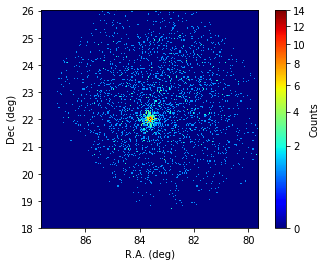

In [5]:
#module used to stretch the color palette
import matplotlib.colors as colors

ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
            extent=[83.63+0.02*200,83.63-0.02*200,22.01-0.02*200,22.01+0.02*200],
            # boundaries of the coord grid
            norm=colors.PowerNorm(gamma=0.5),
            cmap=plt.get_cmap('jet')) # square root scale 
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')

## Defining a source model
We can see there is a source in the very center of the above map. For the next step let's imagine we didn't know what it was or that it was there. `cssrcdetect` is a low level source detection tool that we can use to search for sources in data.

In [6]:
# Initialize the detection script
srcdetect = cscripts.cssrcdetect(skymap.skymap().copy())

# Set the parameters
srcdetect['srcmodel']   = 'POINT' # Output point source models
srcdetect['bkgmodel']   = 'NONE'
srcdetect['threshold']  = 5
srcdetect['corr_rad']   = 0.1     # Smoothing radius
srcdetect['outmodel']   = 'resources/crab.xml'
srcdetect['outds9file'] = 'resources/crab_regions.reg'
srcdetect.execute()

# Inspect the results
models = gammalib.GModels(srcdetect['outmodel'].filename())
print(models)

=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 6
=== GModelSky ===
 Name ......................: Src001
 Instruments ...............: all
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.6222127881284 +/- 0 deg (free,scale=1)
  DEC ......................: 22.0244996471388 +/- 0 deg (free,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 5.7e-18 +/- 0 [0,infty[ ph/cm2/s/MeV (free,scale=5.7e-18,gradient)
  Index ....................: -2.48 +/- 0 [10,-10]  (free,scale=-2.48,gradient)
  PivotEnergy ..............: 300000 MeV (fixed,scale=300000,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed,scale=1,gradient)
 Number of scale par's .....: 0


So we see above that we detect a source at roughly the Crab position! This file will NOT serve as our input model for the rest of the analysis, but demonstrates one method for probing your data for sources. You can also create these models in alternative ways:
* **Programmatically**: Create individual models via GammaLib model classes, then assemble them into a GModels collection
* **By hand**: Creating and modifying an XML file directly

### Summary
We now have a formatted input file for our observations and our model. Next steps will include generating the ON/OFF input files (`csphagen`) and ultimately running the fit (`ctlike`).

** Additional Resources **
* [ctools tutorials](http://cta.irap.omp.eu/ctools/users/tutorials/index.html)
* [GammaLib spatial models](http://cta.irap.omp.eu/gammalib/users/user_manual/modules/model/sky/spatial.html)
* [GammaLib spectral models](http://cta.irap.omp.eu/gammalib/users/user_manual/modules/model/sky/spectral.html)
* [GammaLib temporal models](http://cta.irap.omp.eu/gammalib/users/user_manual/modules/model/sky/temporal.html)